In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df_train_est_A = pd.read_csv('train_est_A.csv')
df_train_obs_A = pd.read_csv('train_obs_A.csv')
df_test_A = pd.read_csv('X_test_A.csv')
df_train_est_A = df_train_est_A.rename(columns={'Unnamed: 0': 'date_forecast'})

df_train_obs_A = df_train_obs_A.rename(columns={'Unnamed: 0': 'date_forecast'})

df_test_A = df_test_A.rename(columns={'Unnamed: 0': 'date_forecast'})

df_train_est_A.set_index('date_forecast', inplace=True)
df_train_obs_A.set_index('date_forecast', inplace=True)
df_test_A.set_index('date_forecast', inplace=True)
df_train_obs_A.index = pd.to_datetime(df_train_obs_A.index)
df_train_obs_A.index = pd.to_datetime(df_train_obs_A.index)


In [ ]:
df = pd.concat([df_train_obs_A,df_train_est_A])
df = df.drop(columns = 'date_calc', axis = 1)
df_test_A = df_test_A.drop(columns = 'date_calc', axis = 1)


In [ ]:
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
df_test_A = df_test_A.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [6]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
# Imputa i valori mancanti
df_knn =pd.DataFrame(imputer.fit_transform(df),columns = df.columns, index = df.index)

In [ ]:
df_knn.shape

In [7]:
columns = df.drop(columns = 'pv_measurement').columns

In [ ]:
df= df_knn

In [ ]:
df.index = pd.to_datetime(df.index)

df['hours'] = df.index.hour


<Axes: xlabel='date_forecast'>

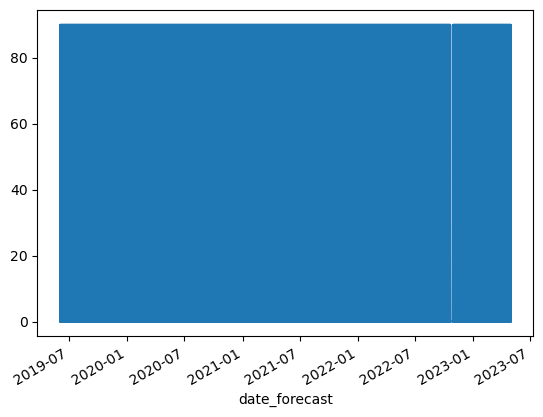

In [33]:
import pandas as pd
import math

# Function to calculate solar zenith angle
def calculate_solar_zenith(row):
    t = row['hours']
    Az = row['sun_azimuthd']
    
    # Calculate the solar zenith angle (θ) using a simplified model
    solar_zenith_angle = 90 - abs(t - 12) * (90 / 6)  # Assumes the sun is highest at noon
    
    # Ensure the solar zenith angle is between 0 and 90 degrees
    solar_zenith_angle = max(0, min(90, solar_zenith_angle))
    
    return solar_zenith_angle

# Apply the function to each row in the DataFrame
df['Solar Zenith Angle (degrees)'] = df.apply(calculate_solar_zenith, axis=1)

# Display the updated DataFrame
df['Solar Zenith Angle (degrees)'].plot()

<Axes: xlabel='date_forecast'>

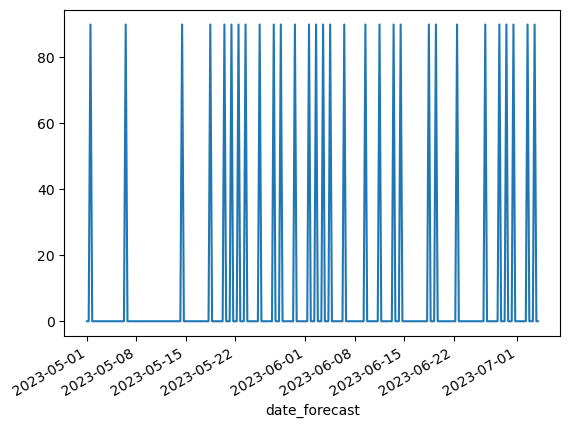

In [34]:
import pandas as pd
import math

# Function to calculate solar zenith angle
def calculate_solar_zenith(row):
    t = row['hours']
    Az = row['sun_azimuthd']
    
    # Calculate the solar zenith angle (θ) using a simplified model
    solar_zenith_angle = 90 - abs(t - 12) * (90 / 6)  # Assumes the sun is highest at noon
    
    # Ensure the solar zenith angle is between 0 and 90 degrees
    solar_zenith_angle = max(0, min(90, solar_zenith_angle))
    
    return solar_zenith_angle

# Apply the function to each row in the DataFrame
df_test_A['Solar Zenith Angle (degrees)'] = df_test_A.apply(calculate_solar_zenith, axis=1)

# Display the updated DataFrame
df_test_A['Solar Zenith Angle (degrees)'].plot()

<Axes: xlabel='date_forecast'>

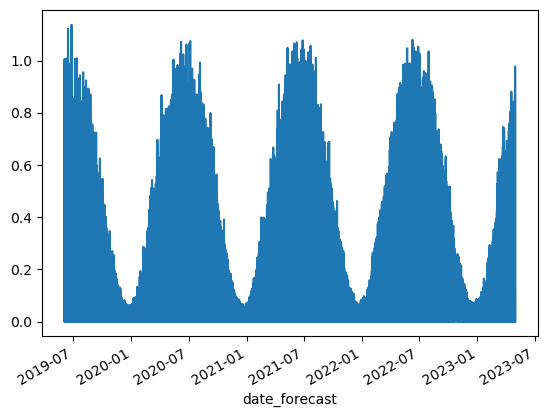

In [35]:
def calculate_total_radiation(row):
    DNI = row['direct_radW']
    solar_zenith_angle = row['Solar Zenith Angle (degrees)']
    DHI = row['diffuse_radW']
    # Calculate total solar radiation (G) using the formula
    G = DNI * math.cos(math.radians(solar_zenith_angle)) + DHI
    
    return G

# Apply the function to each row in the DataFrame
df['Total Solar Radiation (W/m²)'] = df.apply(calculate_total_radiation, axis=1)
df['Total Solar Radiation (W/m²)'].plot()

<Axes: xlabel='date_forecast'>

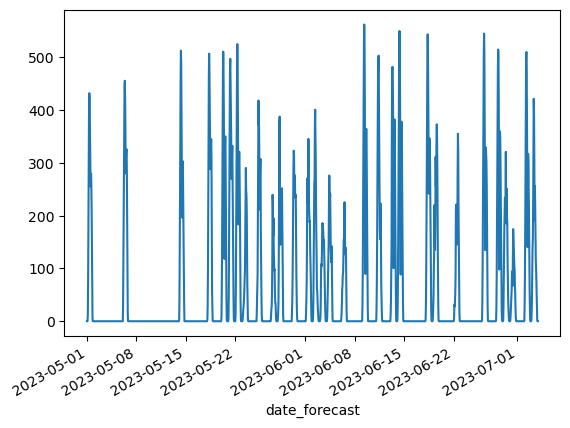

In [36]:
def calculate_total_radiation(row):
    DNI = row['direct_radW']
    solar_zenith_angle = row['Solar Zenith Angle (degrees)']
    DHI = row['diffuse_radW']
    # Calculate total solar radiation (G) using the formula
    G = DNI * math.cos(math.radians(solar_zenith_angle)) + DHI
    
    return G

# Apply the function to each row in the DataFrame
df_test_A['Total Solar Radiation (W/m²)'] = df_test_A.apply(calculate_total_radiation, axis=1)
df_test_A['Total Solar Radiation (W/m²)'].plot()

In [ ]:
df = df[columns]

In [ ]:
def outlier_detect_IQR(data,col,threshold=3):
    '''
    outlier detection by Interquartile Ranges Rule, also known as Tukey's test. 
    calculate the IQR ( 75th quantile - 25th quantile) 
    and the 25th 75th quantile. 
    Any value beyond:
        upper bound = 75th quantile + （IQR * threshold）
        lower bound = 25th quantile - （IQR * threshold）   
    are regarded as outliers. Default threshold is 3.
    '''
     
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    Lower_fence = data[col].quantile(0.25) - (IQR * threshold)
    Upper_fence = data[col].quantile(0.75) + (IQR * threshold)
    para = (Upper_fence, Lower_fence)
    tmp = pd.concat([data[col]>Upper_fence,data[col]<Lower_fence],axis=1)
    outlier_index = tmp.any(axis=1)
    if outlier_index.any():
        num_outliers = outlier_index.value_counts()[True]
        print(f'Num of outliers detected: {num_outliers} in column {col}')
    else:
        print(f"No outliers detected in the data in column {col}")
    return outlier_index, para

In [ ]:
for col in df.columns:
    outlier_index, para = outlier_detect_IQR(df,col)

In [8]:
from sklearn.preprocessing import MinMaxScaler
# Crea un oggetto MinMaaxScaler
scaler = MinMaxScaler()
# Normalizza il DataFrame
df_normalized = pd.DataFrame(scaler.fit_transform(df),columns = df.columns, index = df.index)
df_normalized['pv_measurement'] = df_knn['pv_measurement']


In [27]:
df = df_normalized
df = df.fillna(0)

In [28]:
df.index = pd.to_datetime(df.index)
df['hours'] = df.index.hour
df['month'] = df.index.month
df_test_A.index = pd.to_datetime(df_test_A.index)
df_test_A['hours'] = df_test_A.index.hour
df_test_A['month'] = df_test_A.index.month
df['hour_sin'] = np.sin(df['hours'] * (2. * np.pi / 24))
df['hour_cos'] = np.cos(df['hours'] * (2. * np.pi / 24))
df['month_sin'] = np.sin((df['month']-1) * (2. * np.pi / 12))
df['month_cos'] = np.cos((df['month']-1) * (2. * np.pi / 12))
df_test_A['hour_sin'] = np.sin(df_test_A['hours'] * (2. * np.pi / 24))
df_test_A['hour_cos'] = np.cos(df_test_A['hours'] * (2. * np.pi / 24))
df_test_A['month_sin'] = np.sin((df_test_A['month']-1) * (2. * np.pi / 12))
df_test_A['month_cos'] = np.cos((df_test_A['month']-1) * (2. * np.pi / 12))
df['direct10'] = df['direct_radW'] *10


In [44]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error
data = df
n_splits = 3
# Initialize the TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits)

In [46]:
import lightgbm as lgb
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_absolute_error
param = {'verbose' : -1}
# Definisci il modello di machine learning
model = lgb.LGBMRegressor(**param)
# Extract target variable for training and testing data
y_train = data['pv_measurement']

# Extract features for training and testing data
X_train = data.drop(columns = 'pv_measurement')  
model.fit(X_train,y_train)
feature_importance = model.feature_importances_  # Use 'split' for Gini importance or 'gain' for gain importance

# Get the names of the features
feature_names = X_train.columns

# Create a DataFrame to display feature importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df = feature_importance_df.reset_index()
print(feature_importance_df)
importance_threshold = 0.1

selected_features = feature_importance_df[feature_importance_df['Importance'] >= importance_threshold]
print(selected_features)

    index                        Feature  Importance
0      10                    direct_radW         204
1      35                   sun_azimuthd         181
2      42             wind_speed_u_10mms         175
3      41               wind_speed_10mms         151
4       5                cloud_base_aglm         148
5      43             wind_speed_v_10mms         134
6       2            ceiling_height_aglm         126
7      38                     t_1000hPaK         120
8       8                   diffuse_radW         117
9      53   Total Solar Radiation (W/m²)         116
10      0        absolute_humidity_2mgm3         104
11     39             total_cloud_coverp         102
12      4                 clear_sky_radW         100
13     28     relative_humidity_1000hPap          95
14      1             air_density_2mkgm3          95
15     21                msl_pressurehPa          91
16     40                    visibilitym          90
17     24               pressure_100mhPa      

In [ ]:
selected_features = rfe.support_
selected_features

In [ ]:
print(rfe.n_features_)
selected_features = rfe.get_feature_names_out()
print(selected_features)

In [85]:
data = df

In [86]:
# Traina il modello sulle feature selezionate
model.fit(data[selected_features['Feature']], data['pv_measurement'])
# Calcola il MAE con le feature selezionate
y_pred = pd.DataFrame(model.predict(data[selected_features['Feature']]),index = data.index)
df['pv_measurement'].plot()
data = data[selected_features['Feature']]
data['pv_measurement'] = df['pv_measurement']
mae = mean_absolute_error(data['pv_measurement'], y_pred)
mae

KeyError: "None of [Index(['direct_radW', 'sun_azimuthd', 'wind_speed_u_10mms', 'wind_speed_10mms',\n       'cloud_base_aglm', 'wind_speed_v_10mms', 'ceiling_height_aglm',\n       't_1000hPaK', 'diffuse_radW', 'Total Solar Radiation (W/m²)',\n       'absolute_humidity_2mgm3', 'total_cloud_coverp', 'clear_sky_radW',\n       'relative_humidity_1000hPap', 'air_density_2mkgm3', 'msl_pressurehPa',\n       'visibilitym', 'pressure_100mhPa', 'dew_point_2mK',\n       'effective_cloud_coverp', 'clear_sky_energy_1hJ', 'diffuse_rad_1hJ',\n       'direct_rad_1hJ', 'month', 'sfc_pressurehPa', 'precip_5minmm',\n       'sun_elevationd', 'snow_waterkgm2', 'super_cooled_liquid_waterkgm2',\n       'fresh_snow_24hcm', 'pressure_50mhPa', 'hour_cos',\n       'precip_type_5minidx', 'month_cos', 'month_sin', 'hour_sin', 'hours',\n       'rain_waterkgm2', 'is_dayidx'],\n      dtype='object')] are in the [columns]"

Number of components to explain 99% of the variance: 3


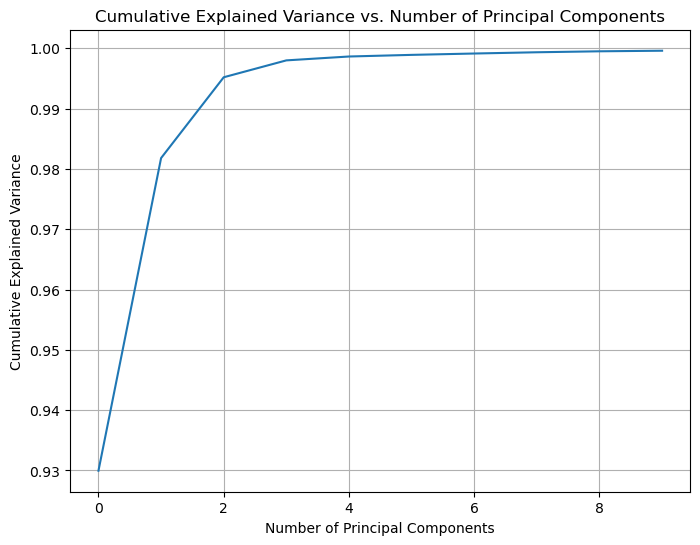

In [23]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA()
pca.fit(X_train)

# Calculate the explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Find the number of components that explain 99% of the variance
cumulative_variance = np.cumsum(explained_variance)
n_components = np.argmax(cumulative_variance >= 0.99) + 1  # Add 1 because indexing starts from 0

# Print the result
print(f"Number of components to explain 99% of the variance: {n_components}")

# Plot the explained variance
plt.figure(figsize=(8, 6))
plt.plot(cumulative_variance[0:10])
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Principal Components')
plt.grid()
plt.show()



In [24]:
def objective(trial):
    param = {
            'metric': 'mae', 
            'random_state': 42,
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
            'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
            'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
            'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4,1e-1),
            'max_depth': trial.suggest_int('max_depth', 1,50),
            'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
            'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
            'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100),
            'verbosity': -1
        }
    maelist = []
    model = lgb.LGBMRegressor(**param)
    for train_index, test_index in tscv.split(data):
        train_data = data.iloc[train_index]
        test_data = data.iloc[test_index]

        # Extract target variable for training and testing data
        y_train = train_data['pv_measurement']
        y_test = test_data['pv_measurement']

        # Extract features for training and testing data
        X_train = train_data.drop(columns = 'pv_measurement')
        X_test = test_data.drop(columns = 'pv_measurement')
        
        # Train the XGBoost model
        model.fit(X_train, y_train,eval_set=[(X_test,y_test)])
        
        # Make predictions on the test data
        y_pred = model.predict(X_test)
        
        # Evaluate the model using Mean Absolute Error (MAE)
        mae = mean_absolute_error(y_test, y_pred)
        print("Mean Absolute Error:", mae)
        maelist.append(mae)
        # Handle pruning based on the intermediate value.

    print("Media : ",np.average(maelist,weights=[1,2,3]))
    return np.average(maelist,weights=[1,2,3])

In [69]:
import optuna
import warnings
warnings.filterwarnings("ignore")
from warnings import simplefilter
simplefilter("ignore", category=RuntimeWarning)
study = optuna.create_study(direction='minimize')

[I 2023-10-28 14:50:21,587] A new study created in memory with name: no-name-4884d796-9939-4c13-a545-3b10a8a9d637


In [73]:
study.optimize(objective, n_trials=50)

Mean Absolute Error: 220.7779837604251
Mean Absolute Error: 200.19215833071888


[I 2023-10-28 14:51:26,583] Trial 14 finished with value: 201.8630567502909 and parameters: {'reg_alpha': 6.791846080102901, 'reg_lambda': 3.6733431846221802, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.09874806477640173, 'max_depth': 24, 'num_leaves': 827, 'min_child_samples': 4, 'min_data_per_groups': 28}. Best is trial 10 with value: 199.7095621436838.


Mean Absolute Error: 196.67201335996083
Media :  201.8630567502909
Mean Absolute Error: 814.5163432364242
Mean Absolute Error: 844.4511313248446


[I 2023-10-28 14:51:28,703] Trial 15 finished with value: 824.959262068682 and parameters: {'reg_alpha': 2.732960996951116, 'reg_lambda': 2.113928776044961, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.00010353295084721836, 'max_depth': 21, 'num_leaves': 986, 'min_child_samples': 48, 'min_data_per_groups': 48}. Best is trial 10 with value: 199.7095621436838.


Mean Absolute Error: 815.4456555086597
Media :  824.959262068682
Mean Absolute Error: 238.55964669460423
Mean Absolute Error: 227.27819230206376


[I 2023-10-28 14:51:30,478] Trial 16 finished with value: 225.15610418449037 and parameters: {'reg_alpha': 9.773032303339471, 'reg_lambda': 8.60420395870616, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.028944141709068765, 'max_depth': 28, 'num_leaves': 756, 'min_child_samples': 49, 'min_data_per_groups': 95}. Best is trial 10 with value: 199.7095621436838.


Mean Absolute Error: 219.27353126940352
Media :  225.15610418449037
Mean Absolute Error: 371.9935543369471
Mean Absolute Error: 379.33506145309536


[I 2023-10-28 14:51:32,465] Trial 17 finished with value: 370.06104272198303 and parameters: {'reg_alpha': 2.8161620415977855, 'reg_lambda': 2.3390224169671407, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.011422021467141386, 'max_depth': 17, 'num_leaves': 827, 'min_child_samples': 44, 'min_data_per_groups': 17}. Best is trial 10 with value: 199.7095621436838.


Mean Absolute Error: 363.23419302958666
Media :  370.06104272198303
Mean Absolute Error: 216.62711007374077
Mean Absolute Error: 198.32744093060964


[I 2023-10-28 14:51:34,991] Trial 18 finished with value: 199.1220468066695 and parameters: {'reg_alpha': 1.4298516593725177, 'reg_lambda': 8.82087739338962, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.04716915279652888, 'max_depth': 26, 'num_leaves': 676, 'min_child_samples': 29, 'min_data_per_groups': 40}. Best is trial 18 with value: 199.1220468066695.


Mean Absolute Error: 193.81676296835232
Media :  199.1220468066695
Mean Absolute Error: 217.04894661600403
Mean Absolute Error: 200.9306897165469


[I 2023-10-28 14:51:36,898] Trial 19 finished with value: 199.78170296305316 and parameters: {'reg_alpha': 0.8325198867958111, 'reg_lambda': 1.5808437297253475, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.04741051033673014, 'max_depth': 27, 'num_leaves': 643, 'min_child_samples': 76, 'min_data_per_groups': 56}. Best is trial 18 with value: 199.1220468066695.


Mean Absolute Error: 193.25996390974043
Media :  199.78170296305316
Mean Absolute Error: 352.75286455573314
Mean Absolute Error: 361.03647245984445


[I 2023-10-28 14:51:41,781] Trial 20 finished with value: 350.78767259128 and parameters: {'reg_alpha': 2.518088764446079, 'reg_lambda': 0.17375206786814593, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.01227143153399451, 'max_depth': 15, 'num_leaves': 486, 'min_child_samples': 30, 'min_data_per_groups': 19}. Best is trial 18 with value: 199.1220468066695.


Mean Absolute Error: 343.30007535741936
Media :  350.78767259128
Mean Absolute Error: 219.02972253159024
Mean Absolute Error: 200.38549793815696


[I 2023-10-28 14:51:44,169] Trial 21 finished with value: 199.2373173109464 and parameters: {'reg_alpha': 1.0747879701879837, 'reg_lambda': 0.04018628192577862, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.0481703446136611, 'max_depth': 37, 'num_leaves': 844, 'min_child_samples': 76, 'min_data_per_groups': 42}. Best is trial 18 with value: 199.1220468066695.


Mean Absolute Error: 191.87439515259143
Media :  199.2373173109464
Mean Absolute Error: 218.76929195358974
Mean Absolute Error: 201.30753177730384


[I 2023-10-28 14:51:46,423] Trial 22 finished with value: 199.60940541576323 and parameters: {'reg_alpha': 1.2541587649982269, 'reg_lambda': 0.04019601711398182, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.04664586700273337, 'max_depth': 37, 'num_leaves': 836, 'min_child_samples': 72, 'min_data_per_groups': 43}. Best is trial 18 with value: 199.1220468066695.


Mean Absolute Error: 192.09069232879398
Media :  199.60940541576323
Mean Absolute Error: 223.11462441836056
Mean Absolute Error: 207.75808996295095


[I 2023-10-28 14:51:48,976] Trial 23 finished with value: 206.1466928474681 and parameters: {'reg_alpha': 0.99567253625944, 'reg_lambda': 0.039013532318756754, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.03644544025239085, 'max_depth': 39, 'num_leaves': 740, 'min_child_samples': 65, 'min_data_per_groups': 45}. Best is trial 18 with value: 199.1220468066695.


Mean Absolute Error: 199.41645091351532
Media :  206.1466928474681
Mean Absolute Error: 300.18722927016495
Mean Absolute Error: 300.81721260971403


[I 2023-10-28 14:51:50,853] Trial 24 finished with value: 294.4969244478156 and parameters: {'reg_alpha': 0.1780471456456253, 'reg_lambda': 0.04912080153977605, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.016689795973987398, 'max_depth': 32, 'num_leaves': 830, 'min_child_samples': 106, 'min_data_per_groups': 58}. Best is trial 18 with value: 199.1220468066695.


Mean Absolute Error: 288.3866307324335
Media :  294.4969244478156
Mean Absolute Error: 217.93772641314817
Mean Absolute Error: 204.16266389649954


[I 2023-10-28 14:51:54,581] Trial 25 finished with value: 201.55842320163754 and parameters: {'reg_alpha': 0.48895075527972626, 'reg_lambda': 0.041659492694829645, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.042476242668598084, 'max_depth': 47, 'num_leaves': 642, 'min_child_samples': 62, 'min_data_per_groups': 40}. Best is trial 18 with value: 199.1220468066695.


Mean Absolute Error: 194.36249500122602
Media :  201.55842320163754
Mean Absolute Error: 426.9160883934145
Mean Absolute Error: 438.01350663708104


[I 2023-10-28 14:51:56,721] Trial 26 finished with value: 427.8262774791383 and parameters: {'reg_alpha': 1.6742985402727675, 'reg_lambda': 0.2160223842686777, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.008955084542048734, 'max_depth': 37, 'num_leaves': 870, 'min_child_samples': 152, 'min_data_per_groups': 52}. Best is trial 18 with value: 199.1220468066695.


Mean Absolute Error: 421.338187735751
Media :  427.8262774791383
Mean Absolute Error: 253.3610933255506
Mean Absolute Error: 244.5270443476993


[I 2023-10-28 14:52:00,141] Trial 27 finished with value: 241.04190714617985 and parameters: {'reg_alpha': 0.14699587422325577, 'reg_lambda': 0.08939304647176442, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.02376400649975237, 'max_depth': 41, 'num_leaves': 728, 'min_child_samples': 34, 'min_data_per_groups': 24}. Best is trial 18 with value: 199.1220468066695.


Mean Absolute Error: 234.61208695204328
Media :  241.04190714617985
Mean Absolute Error: 225.71043554901505
Mean Absolute Error: 200.71553351846842


[I 2023-10-28 14:52:02,672] Trial 28 finished with value: 201.47207591982988 and parameters: {'reg_alpha': 3.5027415659024177, 'reg_lambda': 0.01691965141760893, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.09324240765866774, 'max_depth': 29, 'num_leaves': 588, 'min_child_samples': 73, 'min_data_per_groups': 63}. Best is trial 18 with value: 199.1220468066695.


Mean Absolute Error: 193.89698431100908
Media :  201.47207591982988
Mean Absolute Error: 218.51153779075943
Mean Absolute Error: 201.7353277090325


[I 2023-10-28 14:52:04,726] Trial 29 finished with value: 200.48057196864315 and parameters: {'reg_alpha': 1.2456510196838984, 'reg_lambda': 0.5673664187783121, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.04634863033765169, 'max_depth': 34, 'num_leaves': 883, 'min_child_samples': 119, 'min_data_per_groups': 40}. Best is trial 18 with value: 199.1220468066695.


Mean Absolute Error: 193.6337462010115
Media :  200.48057196864315
Mean Absolute Error: 286.11796813548864
Mean Absolute Error: 284.54878120609067


[I 2023-10-28 14:52:07,203] Trial 30 finished with value: 279.77556292996206 and parameters: {'reg_alpha': 0.7581147818825863, 'reg_lambda': 0.0162797847649066, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.018483049524898848, 'max_depth': 45, 'num_leaves': 543, 'min_child_samples': 157, 'min_data_per_groups': 84}. Best is trial 18 with value: 199.1220468066695.


Mean Absolute Error: 274.4792823440341
Media :  279.77556292996206
Mean Absolute Error: 219.58391340289126
Mean Absolute Error: 199.16995147082588


[I 2023-10-28 14:52:12,084] Trial 31 finished with value: 199.23187612598755 and parameters: {'reg_alpha': 3.99388857036437, 'reg_lambda': 0.07107254503734821, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.05503954438261788, 'max_depth': 36, 'num_leaves': 674, 'min_child_samples': 23, 'min_data_per_groups': 13}. Best is trial 18 with value: 199.1220468066695.


Mean Absolute Error: 192.48914680379409
Media :  199.23187612598755
Mean Absolute Error: 224.31871197367943
Mean Absolute Error: 207.2146668333156


[I 2023-10-28 14:52:17,152] Trial 32 finished with value: 206.2383079375571 and parameters: {'reg_alpha': 3.8677844085964668, 'reg_lambda': 0.078712657631862, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.037093166666384424, 'max_depth': 36, 'num_leaves': 688, 'min_child_samples': 23, 'min_data_per_groups': 12}. Best is trial 18 with value: 199.1220468066695.


Mean Absolute Error: 199.56060066167734
Media :  206.2383079375571
Mean Absolute Error: 218.4688383046223
Mean Absolute Error: 198.68651782427267


[I 2023-10-28 14:52:19,562] Trial 33 finished with value: 198.5406224316125 and parameters: {'reg_alpha': 1.4493893655485879, 'reg_lambda': 0.030945769566179653, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.060444691489266414, 'max_depth': 41, 'num_leaves': 791, 'min_child_samples': 85, 'min_data_per_groups': 32}. Best is trial 33 with value: 198.5406224316125.


Mean Absolute Error: 191.8006202121691
Media :  198.5406224316125
Mean Absolute Error: 219.8553141640064
Mean Absolute Error: 199.43629617749832


[I 2023-10-28 14:52:21,690] Trial 34 finished with value: 198.766952144089 and parameters: {'reg_alpha': 3.8887549124730665, 'reg_lambda': 0.15664554921295024, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.0659284995437181, 'max_depth': 41, 'num_leaves': 770, 'min_child_samples': 91, 'min_data_per_groups': 32}. Best is trial 33 with value: 198.5406224316125.


Mean Absolute Error: 191.29126878184366
Media :  198.766952144089
Mean Absolute Error: 227.79775907209614
Mean Absolute Error: 200.28499377251134


[I 2023-10-28 14:52:23,498] Trial 35 finished with value: 201.53681593942656 and parameters: {'reg_alpha': 4.6293952283619735, 'reg_lambda': 0.26488312385207735, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.09780033323217031, 'max_depth': 44, 'num_leaves': 555, 'min_child_samples': 184, 'min_data_per_groups': 20}. Best is trial 33 with value: 198.5406224316125.


Mean Absolute Error: 193.6177163398135
Media :  201.53681593942656
Mean Absolute Error: 230.58936528890925
Mean Absolute Error: 221.48824720288087


[I 2023-10-28 14:52:25,315] Trial 36 finished with value: 218.4631605084256 and parameters: {'reg_alpha': 5.391921371921481, 'reg_lambda': 0.1721528734233164, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.029862476418162198, 'max_depth': 49, 'num_leaves': 782, 'min_child_samples': 94, 'min_data_per_groups': 10}. Best is trial 33 with value: 198.5406224316125.


Mean Absolute Error: 212.40436778529423
Media :  218.4631605084256
Mean Absolute Error: 221.08774867584125
Mean Absolute Error: 198.20976136634673


[I 2023-10-28 14:52:28,035] Trial 37 finished with value: 199.46423927103294 and parameters: {'reg_alpha': 2.0680754012713303, 'reg_lambda': 0.3491463914555296, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.06419062314037474, 'max_depth': 41, 'num_leaves': 692, 'min_child_samples': 52, 'min_data_per_groups': 32}. Best is trial 33 with value: 198.5406224316125.


Mean Absolute Error: 193.0927214058876
Media :  199.46423927103294
Mean Absolute Error: 220.37673495252324
Mean Absolute Error: 199.4326770350564


[I 2023-10-28 14:52:31,519] Trial 38 finished with value: 199.52802361435397 and parameters: {'reg_alpha': 4.074643514953596, 'reg_lambda': 0.8634017047626236, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.06671769961578158, 'max_depth': 32, 'num_leaves': 411, 'min_child_samples': 30, 'min_data_per_groups': 13}. Best is trial 33 with value: 198.5406224316125.


Mean Absolute Error: 192.64201755449594
Media :  199.52802361435397
Mean Absolute Error: 267.80818275701745
Mean Absolute Error: 257.8723174507258


[I 2023-10-28 14:52:32,708] Trial 39 finished with value: 254.5960601931946 and parameters: {'reg_alpha': 1.7554487882825298, 'reg_lambda': 0.14043988169405777, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.023291695274668244, 'max_depth': 44, 'num_leaves': 53, 'min_child_samples': 171, 'min_data_per_groups': 25}. Best is trial 33 with value: 198.5406224316125.


Mean Absolute Error: 248.0078478335662
Media :  254.5960601931946
Mean Absolute Error: 229.18562301709164
Mean Absolute Error: 217.8864894502679


[I 2023-10-28 14:52:34,368] Trial 40 finished with value: 215.76590330104173 and parameters: {'reg_alpha': 0.5679034772283291, 'reg_lambda': 0.4539373090307638, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.03151262783151358, 'max_depth': 25, 'num_leaves': 674, 'min_child_samples': 132, 'min_data_per_groups': 35}. Best is trial 33 with value: 198.5406224316125.


Mean Absolute Error: 209.87893929620762
Media :  215.76590330104173
Mean Absolute Error: 223.08659254103395
Mean Absolute Error: 201.74254377955467


[I 2023-10-28 14:52:35,964] Trial 41 finished with value: 202.07560096831818 and parameters: {'reg_alpha': 5.445692206373928, 'reg_lambda': 0.004669446700638434, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.06637883248912922, 'max_depth': 47, 'num_leaves': 608, 'min_child_samples': 239, 'min_data_per_groups': 30}. Best is trial 33 with value: 198.5406224316125.


Mean Absolute Error: 195.29397523658855
Media :  202.07560096831818
Mean Absolute Error: 217.04380866882002
Mean Absolute Error: 200.7618562999454


[I 2023-10-28 14:52:38,208] Trial 42 finished with value: 198.89950561719152 and parameters: {'reg_alpha': 1.3699077890480031, 'reg_lambda': 0.08807494029533249, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.0484374683291369, 'max_depth': 39, 'num_leaves': 802, 'min_child_samples': 85, 'min_data_per_groups': 38}. Best is trial 33 with value: 198.5406224316125.


Mean Absolute Error: 191.6098374781461
Media :  198.89950561719152
Mean Absolute Error: 230.6571067811792
Mean Absolute Error: 221.42798218105037


[I 2023-10-28 14:52:40,074] Trial 43 finished with value: 217.96402980678135 and parameters: {'reg_alpha': 2.8064485614984385, 'reg_lambda': 0.10693549316462463, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.03008288044809864, 'max_depth': 39, 'num_leaves': 781, 'min_child_samples': 102, 'min_data_per_groups': 48}. Best is trial 33 with value: 198.5406224316125.


Mean Absolute Error: 211.42370256580267
Media :  217.96402980678135
Mean Absolute Error: 219.70451123604798
Mean Absolute Error: 198.89718104504416


[I 2023-10-28 14:52:41,972] Trial 44 finished with value: 199.23168359979672 and parameters: {'reg_alpha': 1.4522610633528343, 'reg_lambda': 0.021548374478490947, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.05734126457095028, 'max_depth': 40, 'num_leaves': 904, 'min_child_samples': 137, 'min_data_per_groups': 21}. Best is trial 33 with value: 198.5406224316125.


Mean Absolute Error: 192.63040942421463
Media :  199.23168359979672
Mean Absolute Error: 251.56282265381844
Mean Absolute Error: 249.52142066392398


[I 2023-10-28 14:52:42,596] Trial 45 finished with value: 248.8851760616485 and parameters: {'reg_alpha': 0.3279133126544417, 'reg_lambda': 0.022350838972565054, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.0790016410522474, 'max_depth': 1, 'num_leaves': 907, 'min_child_samples': 135, 'min_data_per_groups': 37}. Best is trial 33 with value: 198.5406224316125.


Mean Absolute Error: 247.56846412940823
Media :  248.8851760616485
Mean Absolute Error: 219.76268384499554
Mean Absolute Error: 208.24389119391782


[I 2023-10-28 14:52:44,559] Trial 46 finished with value: 205.90543736677463 and parameters: {'reg_alpha': 0.5547571496156046, 'reg_lambda': 0.009023610126718555, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.03760886742134059, 'max_depth': 42, 'num_leaves': 917, 'min_child_samples': 111, 'min_data_per_groups': 21}. Best is trial 33 with value: 198.5406224316125.


Mean Absolute Error: 199.72738598927222
Media :  205.90543736677463
Mean Absolute Error: 284.1650936608239
Mean Absolute Error: 279.06673046088434


[I 2023-10-28 14:52:46,229] Trial 47 finished with value: 274.3773071338425 and parameters: {'reg_alpha': 1.4711594222579754, 'reg_lambda': 0.2993983257732471, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.019572914114884838, 'max_depth': 34, 'num_leaves': 791, 'min_child_samples': 88, 'min_data_per_groups': 29}. Best is trial 33 with value: 198.5406224316125.


Mean Absolute Error: 267.98842940682084
Media :  274.3773071338425
Mean Absolute Error: 224.0003646944629
Mean Absolute Error: 199.8012785765887


[I 2023-10-28 14:52:47,530] Trial 48 finished with value: 200.2741941401613 and parameters: {'reg_alpha': 0.7637922826356744, 'reg_lambda': 0.810511011759932, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.08074839595587409, 'max_depth': 7, 'num_leaves': 943, 'min_child_samples': 138, 'min_data_per_groups': 34}. Best is trial 33 with value: 198.5406224316125.


Mean Absolute Error: 192.68074766444252
Media :  200.2741941401613
Mean Absolute Error: 222.3509664671089
Mean Absolute Error: 200.89001963552872


[I 2023-10-28 14:52:49,139] Trial 49 finished with value: 200.20667384877228 and parameters: {'reg_alpha': 1.7771405925256438, 'reg_lambda': 0.0575814669926836, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.0659578958546172, 'max_depth': 50, 'num_leaves': 882, 'min_child_samples': 205, 'min_data_per_groups': 51}. Best is trial 33 with value: 198.5406224316125.


Mean Absolute Error: 192.3696791181558
Media :  200.20667384877228
Mean Absolute Error: 226.32109848049234
Mean Absolute Error: 200.35463730237362


[I 2023-10-28 14:52:51,573] Trial 50 finished with value: 201.43833217191013 and parameters: {'reg_alpha': 0.31605125361021535, 'reg_lambda': 0.027377384189839763, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.09836310620749512, 'max_depth': 40, 'num_leaves': 787, 'min_child_samples': 89, 'min_data_per_groups': 37}. Best is trial 33 with value: 198.5406224316125.


Mean Absolute Error: 193.86653998207373
Media :  201.43833217191013
Mean Absolute Error: 243.9502530605913
Mean Absolute Error: 236.932570636024


[I 2023-10-28 14:52:53,633] Trial 51 finished with value: 233.00581702654586 and parameters: {'reg_alpha': 2.1240258915692802, 'reg_lambda': 0.11979329468233846, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.02554229287345622, 'max_depth': 45, 'num_leaves': 732, 'min_child_samples': 112, 'min_data_per_groups': 24}. Best is trial 33 with value: 198.5406224316125.


Mean Absolute Error: 226.73983594221195
Media :  233.00581702654586
Mean Absolute Error: 218.97883367264984
Mean Absolute Error: 200.16358743455078


[I 2023-10-28 14:52:59,006] Trial 52 finished with value: 199.958918520933 and parameters: {'reg_alpha': 7.071275287283664, 'reg_lambda': 0.07411167620830524, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.05334965885586285, 'max_depth': 30, 'num_leaves': 660, 'min_child_samples': 19, 'min_data_per_groups': 6}. Best is trial 33 with value: 198.5406224316125.


Mean Absolute Error: 193.48250086128215
Media :  199.958918520933
Mean Absolute Error: 218.74239309691706
Mean Absolute Error: 198.26245586645103


[I 2023-10-28 14:53:01,536] Trial 53 finished with value: 198.5753971844845 and parameters: {'reg_alpha': 3.489368578205202, 'reg_lambda': 0.07365646652523165, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.0573243260623747, 'max_depth': 35, 'num_leaves': 693, 'min_child_samples': 59, 'min_data_per_groups': 17}. Best is trial 33 with value: 198.5406224316125.


Mean Absolute Error: 192.06169275902934
Media :  198.5753971844845
Mean Absolute Error: 220.73816475539044
Mean Absolute Error: 205.64429310995956


[I 2023-10-28 14:53:04,207] Trial 54 finished with value: 204.20656465016467 and parameters: {'reg_alpha': 1.3381908599305155, 'reg_lambda': 0.13221525582571816, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.037997520173487, 'max_depth': 34, 'num_leaves': 707, 'min_child_samples': 54, 'min_data_per_groups': 18}. Best is trial 33 with value: 198.5406224316125.


Mean Absolute Error: 197.7375456418928
Media :  204.20656465016467
Mean Absolute Error: 216.5831970833644
Mean Absolute Error: 198.62346248541823


[I 2023-10-28 14:53:06,381] Trial 55 finished with value: 198.61541446459887 and parameters: {'reg_alpha': 2.769040753360699, 'reg_lambda': 6.068843491120462, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.05438350247645588, 'max_depth': 43, 'num_leaves': 809, 'min_child_samples': 81, 'min_data_per_groups': 30}. Best is trial 33 with value: 198.5406224316125.


Mean Absolute Error: 192.62078824446414
Media :  198.61541446459887
Mean Absolute Error: 224.06821532202298
Mean Absolute Error: 198.5015910578236


[I 2023-10-28 14:53:08,751] Trial 56 finished with value: 199.1055332690905 and parameters: {'reg_alpha': 2.983847687855243, 'reg_lambda': 5.914443466948783, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.0768606368740958, 'max_depth': 42, 'num_leaves': 762, 'min_child_samples': 80, 'min_data_per_groups': 31}. Best is trial 33 with value: 198.5406224316125.


Mean Absolute Error: 191.18726739229095
Media :  199.1055332690905
Mean Absolute Error: 221.19088953453266
Mean Absolute Error: 199.09368416737303


[I 2023-10-28 14:53:11,148] Trial 57 finished with value: 198.53536416887096 and parameters: {'reg_alpha': 2.618637703610074, 'reg_lambda': 5.71426713138862, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.07436490668309158, 'max_depth': 43, 'num_leaves': 205, 'min_child_samples': 83, 'min_data_per_groups': 1}. Best is trial 57 with value: 198.53536416887096.


Mean Absolute Error: 190.6113090479823
Media :  198.53536416887096
Mean Absolute Error: 216.56308053715622
Mean Absolute Error: 198.6420843717442


[I 2023-10-28 14:53:13,633] Trial 58 finished with value: 198.00636358000466 and parameters: {'reg_alpha': 6.010951507375131, 'reg_lambda': 2.837292955549844, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.05485232524469839, 'max_depth': 48, 'num_leaves': 143, 'min_child_samples': 63, 'min_data_per_groups': 3}. Best is trial 58 with value: 198.00636358000466.


Mean Absolute Error: 191.39697739979448
Media :  198.00636358000466
Mean Absolute Error: 220.29378523027205
Mean Absolute Error: 198.98433542450206


[I 2023-10-28 14:53:16,211] Trial 59 finished with value: 199.0965041207448 and parameters: {'reg_alpha': 9.409139807551734, 'reg_lambda': 2.987261815760373, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.07462107952767136, 'max_depth': 47, 'num_leaves': 200, 'min_child_samples': 60, 'min_data_per_groups': 4}. Best is trial 58 with value: 198.00636358000466.


Mean Absolute Error: 192.10552288173088
Media :  199.0965041207448
Mean Absolute Error: 226.0965325002069
Mean Absolute Error: 213.67537219531974


[I 2023-10-28 14:53:19,345] Trial 60 finished with value: 211.59175881235504 and parameters: {'reg_alpha': 6.0604763475658245, 'reg_lambda': 4.094227168851973, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.033519608131648705, 'max_depth': 48, 'num_leaves': 249, 'min_child_samples': 39, 'min_data_per_groups': 2}. Best is trial 58 with value: 198.00636358000466.


Mean Absolute Error: 205.36775866109463
Media :  211.59175881235504
Mean Absolute Error: 218.40408304686213
Mean Absolute Error: 198.4693469411399


[I 2023-10-28 14:53:21,441] Trial 61 finished with value: 197.41427362797086 and parameters: {'reg_alpha': 7.3305905614262965, 'reg_lambda': 5.401584816914185, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.05642016281410264, 'max_depth': 43, 'num_leaves': 87, 'min_child_samples': 68, 'min_data_per_groups': 9}. Best is trial 61 with value: 197.41427362797086.


Mean Absolute Error: 189.71428827956106
Media :  197.41427362797086
Mean Absolute Error: 217.2678417446845
Mean Absolute Error: 198.3328526726984


[I 2023-10-28 14:53:23,569] Trial 62 finished with value: 198.20560570941066 and parameters: {'reg_alpha': 6.907649272927293, 'reg_lambda': 4.614992955160319, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.05492936988808044, 'max_depth': 43, 'num_leaves': 103, 'min_child_samples': 70, 'min_data_per_groups': 9}. Best is trial 61 with value: 197.41427362797086.


Mean Absolute Error: 191.7666957221276
Media :  198.20560570941066
Mean Absolute Error: 219.3624143259468
Mean Absolute Error: 202.63109753163903


[I 2023-10-28 14:53:25,460] Trial 63 finished with value: 202.3008071144634 and parameters: {'reg_alpha': 7.127663481417382, 'reg_lambda': 5.857683890613295, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.04230838118341376, 'max_depth': 43, 'num_leaves': 98, 'min_child_samples': 64, 'min_data_per_groups': 8}. Best is trial 61 with value: 197.41427362797086.


Mean Absolute Error: 196.39341109918522
Media :  202.3008071144634


In [74]:
trial = study.best_trial

print("  Value: {}".format(trial.value))
print(trial.params)

  Value: 197.41427362797086
{'reg_alpha': 7.3305905614262965, 'reg_lambda': 5.401584816914185, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.05642016281410264, 'max_depth': 43, 'num_leaves': 87, 'min_child_samples': 68, 'min_data_per_groups': 9}


In [75]:
param ={'reg_alpha': 7.3305905614262965, 'reg_lambda': 5.401584816914185, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.05642016281410264, 'max_depth': 43, 'num_leaves': 87, 'min_child_samples': 68, 'min_data_per_groups': 9}

In [76]:
model_A = lgb.LGBMRegressor(**param)

In [77]:
X_train = data.drop(columns = 'pv_measurement')
y_train = data['pv_measurement']

In [83]:
model_A.fit(X_train,y_train)
df_test_A = df_test_A[selected_features['Feature']]
y_pred_A = model_A.predict(df_test_A)
df_test_A

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7339
[LightGBM] [Info] Number of data points in the train set: 34085, number of used features: 39
[LightGBM] [Info] Start training from score 630.594707
[LightGBM] [Warning] Unknown parameter: min_data_per_groups


,direct_radW,sun_azimuthd,wind_speed_u_10mms,wind_speed_10mms,cloud_base_aglm,wind_speed_v_10mms,ceiling_height_aglm,t_1000hPaK,diffuse_radW,Total Solar Radiation (W/m²),...,fresh_snow_24hcm,pressure_50mhPa,hour_cos,precip_type_5minidx,month_cos,month_sin,hour_sin,hours,rain_waterkgm2,is_dayidx
date_forecast,,,,,,,,,,,,,,,,,,,,,
2023-05-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-05-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-05-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-05-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-05-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-03 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-03 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-03 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


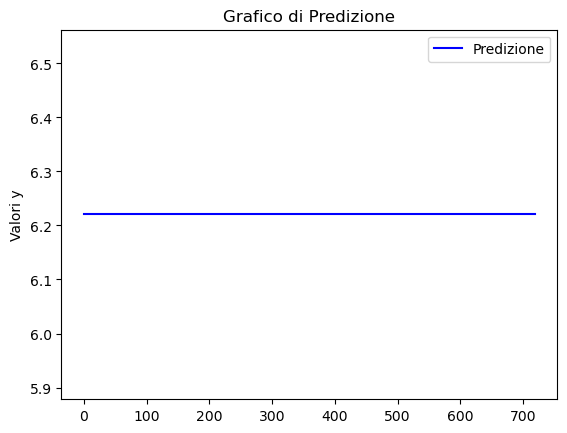

In [80]:
plt.plot(range(len(y_pred_A)), y_pred_A, label='Predizione', color='blue', linestyle='-')

# Aggiungi una legenda
plt.legend()

# Aggiungi etichette agli assi
plt.ylabel('Valori y')

# Titolo del grafico
plt.title('Grafico di Predizione')

# Mostra il grafico
plt.show()

In [81]:
df = pd.DataFrame({'Prediction':y_pred_A})

In [ ]:
threshold = 0.05
df['Prediction'] = df['Prediction'].apply(lambda x: 0 if x < threshold else x)

In [ ]:
df.to_csv('A.csv')

In [82]:
df.tail(50)

,Prediction
670,6.220357
671,6.220357
672,6.220357
673,6.220357
674,6.220357
675,6.220357
676,6.220357
677,6.220357
678,6.220357
679,6.220357


In [ ]:
data['pv_measurement'][0:720].plot()

In [ ]:
df_normalized['pv_measurement'] =( ((df_normalized['pv_measurement'] * lambda_value) + 1)   ** (1 / lambda_value)) -1
df_normalized['pv_measurement']

In [ ]:
df_knn['pv_measurement']